## This notebook contains routines to analyze the electric load profiles from PG&E office building
#### Brief description of this workflow:
1. Pre-processing (skip this step your if you have cleaned data)
    - Extract data for a building type (e.g. office building in our case)
    - Remove empty and problematic data
    - Convert data into dataframes ([example](../data_all/1004541105.csv))
    - Get typical building load profiles
        - Create annual heatmaps
        - Use pre-trained CNN model and k-means clustering to distinguish typical building loads (high-load during daytime) and non-typical loads (e.g., high-load during night time)
2. Conduct Frequency-Domain analysis
    - Annual analysis
        - Create bins to group high, medium, and low frequency features
    - Daily analysis
        - How

### Step 1. Pre-processing
Previously, we found some load profiles have high-peak during the night time, we want to explore how those load profile look like and whether we should separate them from typical load profiles.

In [1]:
%pwd
%cd ..

/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP


#### Import libraries and set up paths

In [2]:
# Import utility functions
# Change directory to the EULP root path, use %cd path_to_EULP
import os
from lib import data_exploration_utils as ex
from lib import frequency_domain_utils as fd
dir_root = %pwd
dir_data = os.path.join(dir_root, "data_all")
dir_fig = os.path.join(dir_root, "fig")

Using TensorFlow backend.
/root/miniconda3/envs/JPTR/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



#### Generate heatmaps and time-series line plot for visualization

In [ ]:
v_ts_CSVs = ex.get_all_file_paths(dir_data, 'csv')
# Create these paths if not exist
dir_heatmaps = os.path.join(dir_fig, "ts_heatmaps")
dir_lines = os.path.join(dir_fig, "ts_lines")

v_valid_ts_CSVs = []
for i, ts_csv in enumerate(v_ts_CSVs):
    sp_id = os.path.basename(ts_csv).split('.')[0]
    df_t = ex.clean_pge_df_ts(ts_csv, 2015).dropna()
    df_t = df_t['Value'].squeeze()
    dir_heatmap = os.path.join(dir_heatmaps, f"{sp_id}.png")
    try:
        ex.generate_heatmap(df_t, dir_heatmap)
        ex.generate_ts_html(df_t, sp_id, dir_lines)
        v_valid_ts_CSVs.append(ts_csv)
    except:
        pass

#### Apply k-means clustering with features generated from pre-trained CNN model

In [13]:
# Get conv base features
v_heatmaps = ex.get_all_file_paths(dir_heatmaps, 'png')
model_conv_base = ex.model_vgg16_conv_base()
v_conv_base_features = [ex.get_conv_base_features(img, model_conv_base).flatten() for img in v_heatmaps]

In [14]:
# Clustering (k=2 because we already know there are two distinct patterns) 
from sklearn.cluster import KMeans
kmeans_step_1 = KMeans(n_clusters=2, random_state=0).fit(v_conv_base_features)

In [16]:
# Copy heatmaps to corresponding cluster folder for comparison
import shutil
kmeans_labels_step_1 = kmeans_step_1.labels_
step_1_out_dir = os.path.join(dir_fig, 'step_1')

for i, label in enumerate(kmeans_labels_step_1):
    cluster_dir = os.path.join(step_1_out_dir, f"cluster_{label}")
    if not os.path.exists(cluster_dir):
        os.mkdir(cluster_dir)
    shutil.copy(v_heatmaps[i], cluster_dir)

In [17]:
# Get the "typical" load profiles
import numpy as np
v_typical_ts_CSVs = list(np.take(v_valid_ts_CSVs, np.where(kmeans_labels_step_1==1))[0]) # Caution: cluster label might be 0 for typical load profiles
v_typical_heatmaps = list(np.take(v_heatmaps, np.where(kmeans_labels_step_1==1))[0])

### Step 2. Frequency-domain analysis

#### Get frequency-domain features at annual window level

In [8]:
# Define hour interval bins
hour_interval_bins = [
    [0.5, 1],
    [1, 2],
    [2, 4],
    [4, 8],
    [8, 12],
    [12, 24],
    [24, 168],
    [168, 9999999],
]

v_valid_ts_csv = []
v_valid_ids = []
for i, ts_csv in enumerate(v_typical_ts_CSVs):
    sp_id = os.path.basename(ts_csv).split('.')[0]
    try:
        df_ts = ex.clean_pge_df_ts(ts_csv, 2015).dropna()
        f_values, fft_values = fd.get_load_fft(df_ts)
        df = fd.get_fft_sum_by_bins(f_values, fft_values, hour_interval_bins)
        if i == 0:
            df_all = df
        else:
            df_all = df_all.append(df)
        v_valid_ts_csv.append(ts_csv)
        v_valid_ids.append(sp_id)
    except:
        pass

df_all.index = np.array([os.path.basename(ts_csv).split('.')[0] for ts_csv in v_valid_ts_csv])
v_valid_typical_heatmaps = [os.path.join(dir_heatmaps, f"{sp_id}.png") for sp_id in v_valid_ids]

/root/miniconda3/envs/JPTR/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [9]:
df_all

,0.5hr ~ 1hr,1hr ~ 2hr,2hr ~ 4hr,4hr ~ 8hr,8hr ~ 12hr,12hr ~ 24hr,24hr ~ 168hr,168hr ~ 9999999hr
1004541105,4.045351,1.825973,1.468645,1.337629,0.663154,1.081967,1.227991,0.305954
1038833405,2.235137,1.259512,0.693115,0.363848,0.212665,0.235400,0.220832,0.091657
1168461705,0.904369,0.691480,0.478640,0.457643,0.250849,0.695328,0.848316,0.480503
1223184997,0.684143,0.792567,0.515768,0.330859,0.169299,0.306253,0.298931,0.100940
1262200205,1.017933,0.820033,0.683613,0.595849,0.328339,0.613614,0.937485,0.468307
...,...,...,...,...,...,...,...,...
9562235840,1.644369,1.457961,1.277493,0.961460,0.430250,0.693644,0.917519,0.282920
9631663705,2.131816,2.061894,1.823427,1.554851,0.811986,1.205264,0.796367,0.494474
9664779554,0.980918,0.748583,0.589968,0.502021,0.243916,0.382425,0.358605,0.100876
9729253659,1.306979,0.918980,0.643070,0.599965,0.208263,0.386633,0.152805,0.148002


In [13]:
df_all.iloc[:, 0:3]
# df_all.iloc[:, 0:3].T.plot()

,0.5hr ~ 1hr,1hr ~ 2hr,2hr ~ 4hr
1004541105,4.045351,1.825973,1.468645
1038833405,2.235137,1.259512,0.693115
1168461705,0.904369,0.691480,0.478640
1223184997,0.684143,0.792567,0.515768
1262200205,1.017933,0.820033,0.683613
...,...,...,...
9562235840,1.644369,1.457961,1.277493
9631663705,2.131816,2.061894,1.823427
9664779554,0.980918,0.748583,0.589968
9729253659,1.306979,0.918980,0.643070


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


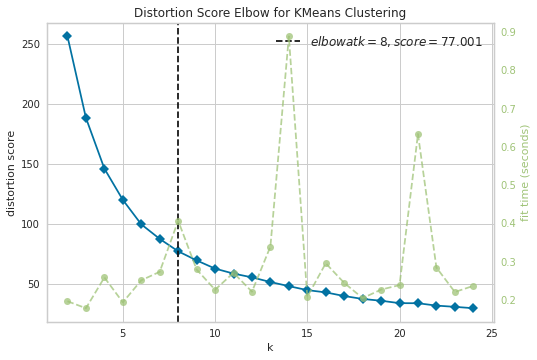

In [10]:
# Select n
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25))
# visualizer.fit(df_all.iloc[:, 0:3].to_numpy())        # Fit the data to the visualizer
visualizer.fit(df_all.to_numpy())        # Fit the data to the visualizer

visualizer.show()        # Finalize and render the figure


In [11]:
# Actual clustering
from sklearn import preprocessing
standard_feature = True
standard_feature = False
scaler = preprocessing.StandardScaler()
if standard_feature:
    fft_data = scaler.fit_transform(df_all)
else:
    fft_data = df_all.iloc[:, 0:3].to_numpy()
    fft_data = df_all.to_numpy()


kmeans_step_2 = KMeans(n_clusters=5, init='random', n_init=3)
kmeans_step_2.fit_predict(fft_data)
kmeans_step_2.labels_.shape

(186,)

In [13]:
# Copy heatmaps to corresponding cluster folder for comparison
import shutil

kmeans_labels_step_2 = kmeans_step_2.labels_
step_2_out_dir = os.path.join(dir_fig, 'step_2')

for i, label in enumerate(kmeans_labels_step_2):
    cluster_dir = os.path.join(step_2_out_dir, f"cluster_{label}")
    if not os.path.exists(cluster_dir):
        os.mkdir(cluster_dir)
    shutil.copy(v_typical_heatmaps[i], cluster_dir)    

In [89]:
len(v_valid_typical_heatmaps)

186

In [14]:
df_all

,0.5hr ~ 1hr,1hr ~ 2hr,2hr ~ 4hr,4hr ~ 8hr,8hr ~ 12hr,12hr ~ 24hr,24hr ~ 168hr,168hr ~ 9999999hr
1004541105,4.045351,1.825973,1.468645,1.337629,0.663154,1.081967,1.227991,0.305954
1038833405,2.235137,1.259512,0.693115,0.363848,0.212665,0.235400,0.220832,0.091657
1168461705,0.904369,0.691480,0.478640,0.457643,0.250849,0.695328,0.848316,0.480503
1223184997,0.684143,0.792567,0.515768,0.330859,0.169299,0.306253,0.298931,0.100940
1262200205,1.017933,0.820033,0.683613,0.595849,0.328339,0.613614,0.937485,0.468307
...,...,...,...,...,...,...,...,...
9562235840,1.644369,1.457961,1.277493,0.961460,0.430250,0.693644,0.917519,0.282920
9631663705,2.131816,2.061894,1.823427,1.554851,0.811986,1.205264,0.796367,0.494474
9664779554,0.980918,0.748583,0.589968,0.502021,0.243916,0.382425,0.358605,0.100876
9729253659,1.306979,0.918980,0.643070,0.599965,0.208263,0.386633,0.152805,0.148002


/root/miniconda3/envs/JPTR/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



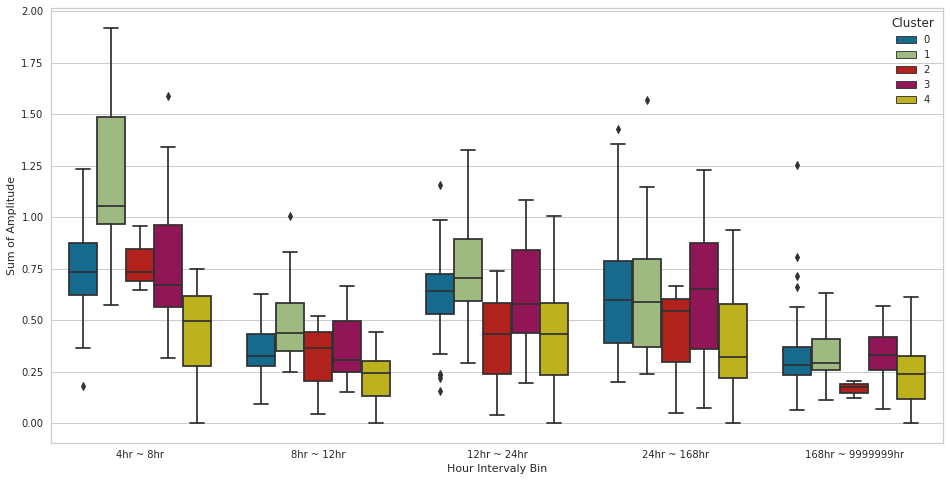

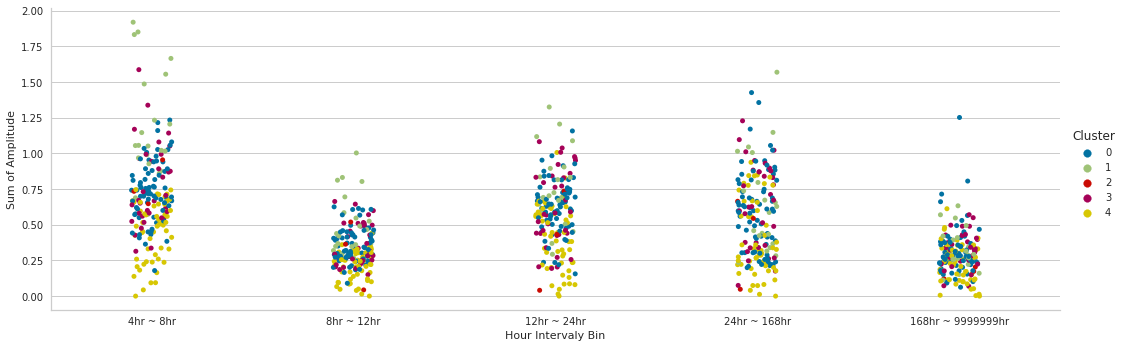

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_plot_raw = df_all.iloc[:, 3:8]
df_plot_raw['Cluster'] = kmeans_labels_step_2

df_plot = pd.melt(df_plot_raw.reset_index(), id_vars=['index', 'Cluster'])
df_plot.columns = ['SP_ID', 'Cluster', 'Hour Intervaly Bin', 'Sum of Amplitude']

plt.figure(figsize=(16,8))
sns.boxplot(data=df_plot,
            x='Hour Intervaly Bin', 
            y='Sum of Amplitude',
            hue='Cluster')


sns.catplot(data=df_plot,
            x='Hour Intervaly Bin', 
            y='Sum of Amplitude',
            hue='Cluster',
            height=5, # make the plot 5 units high
            aspect=3)

### Get frequency-domain features at monthly window level

In [4]:

# Define hour interval bins
hour_interval_bins = [
    [0.5, 1],
    [1, 2],
    [2, 4],
    [4, 8],
    [8, 12],
    [12, 24],
    [24, 168],
    [168, 9999999],
]

get_annual_feature = False

v_valid_ts_csv = []
v_valid_ids = []
for i, ts_csv in enumerate(v_typical_ts_CSVs):
    sp_id = os.path.basename(ts_csv).split('.')[0]
    df_ts = ex.clean_pge_df_ts(ts_csv, 2015).dropna()
    try:
        if get_annual_feature:
            # Gel annual bins
            f_values, fft_values = fd.get_load_fft(df_ts)
            df = fd.get_fft_sum_by_bins(f_values, fft_values, hour_interval_bins)
        else:
            # Get monthly bins
            v_bin_sums = []
            v_bin_names = []
            for m in range(1, 13):
                df_ts_month = df_ts.iloc[df_ts.index.month == m, :].dropna()
                f_values, fft_values = fd.get_load_fft(df_ts_month)
                df = fd.get_fft_sum_by_bins(f_values, fft_values, hour_interval_bins)
                month_col_names = [f"{m}_{hour_bin}" for hour_bin in df.columns]
                v_bin_names+=month_col_names
                v_bin_sums+=list(df.iloc[0])
            df = pd.DataFrame(columns=v_bin_names)
            df.loc[sp_id] = v_bin_sums

        if i == 0:
            df_all = df
        else:
            df_all = df_all.append(df)
        v_valid_ts_csv.append(ts_csv)
        v_valid_ids.append(sp_id)
    except:
        pass

df_all.index = np.array([os.path.basename(ts_csv).split('.')[0] for ts_csv in v_valid_ts_csv])
v_valid_typical_heatmaps = [os.path.join(dir_heatmaps, f"{sp_id}.png") for sp_id in v_valid_ids]


NameError: name 'v_typical_ts_CSVs' is not defined

In [120]:
df_all


,1_0.5hr ~ 1hr,1_1hr ~ 2hr,1_2hr ~ 4hr,1_4hr ~ 8hr,1_8hr ~ 12hr,1_12hr ~ 24hr,1_24hr ~ 168hr,1_168hr ~ 9999999hr,2_0.5hr ~ 1hr,2_1hr ~ 2hr,...,11_24hr ~ 168hr,11_168hr ~ 9999999hr,12_0.5hr ~ 1hr,12_1hr ~ 2hr,12_2hr ~ 4hr,12_4hr ~ 8hr,12_8hr ~ 12hr,12_12hr ~ 24hr,12_24hr ~ 168hr,12_168hr ~ 9999999hr
1004541105,0.123158,0.124143,0.143019,0.138214,0.084567,0.125797,0.158496,0.090936,0.086464,0.098905,...,0.105966,0.039925,0.136107,0.161501,0.137153,0.120012,0.052085,0.066176,0.071550,0.044300
1038833405,0.759707,0.372361,0.178751,0.065671,0.006406,0.006390,0.004260,0.022160,0.659779,0.376248,...,0.000204,0.000049,0.005242,0.003442,0.002289,0.001326,0.000457,0.000463,0.000354,0.000086
1168461705,0.138963,0.094021,0.089745,0.084437,0.043341,0.188378,0.239627,0.145448,0.174238,0.122127,...,0.261964,0.130445,0.130599,0.118157,0.093127,0.105281,0.042431,0.198636,0.248440,0.129093
1223184997,0.326430,0.425465,0.357582,0.207266,0.062214,0.129203,0.123225,0.055501,0.204629,0.287751,...,0.107280,0.042648,0.424197,0.423687,0.368256,0.264085,0.094753,0.154931,0.139857,0.058157
1262200205,0.313000,0.262352,0.211791,0.245370,0.139423,0.399891,0.482713,0.321097,0.270999,0.239613,...,0.362375,0.280301,0.342971,0.287046,0.245736,0.244574,0.134011,0.378782,0.599004,0.323827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9562235840,0.498956,0.487253,0.435793,0.417030,0.168197,0.377581,0.431951,0.171309,0.442181,0.439981,...,0.450693,0.185261,0.470304,0.403504,0.454418,0.365668,0.175490,0.372679,0.463784,0.164437
9631663705,0.783298,0.899737,0.829490,0.779568,0.493475,0.586997,0.377698,0.406314,0.828917,0.766360,...,0.265143,0.265239,0.910727,0.744798,0.774578,0.618927,0.414530,0.505042,0.310249,0.349169
9664779554,0.801515,0.430547,0.228742,0.146564,0.063973,0.092014,0.070980,0.035243,0.147354,0.090206,...,0.148312,0.059935,1.215235,0.590275,0.479029,0.399929,0.207931,0.253654,0.255424,0.133516
9729253659,0.323550,0.255085,0.228762,0.198347,0.125232,0.306061,0.107428,0.176361,0.483489,0.438565,...,0.126270,0.198951,0.350466,0.285368,0.271261,0.255193,0.206139,0.376342,0.113266,0.198206


In [188]:

scaler.fit_transform(df_all)

array([[-1.01046249, -1.14991367, -0.87198848, ..., -1.02622209,
        -1.14013175, -0.6515544 ],
       [ 0.62502708,  0.01687839, -0.66153002, ..., -1.62631348,
        -1.58937361,  0.16977122],
       [-0.96985548, -1.29150409, -1.18576732, ...,  0.46473557,
        -0.27858741,  0.99109684],
       ...,
       [ 0.73244466,  0.2903924 , -0.36708602, ...,  0.52360161,
        -0.23364747,  0.16977122],
       [-0.49559329, -0.53439678, -0.36697236, ..., -0.67460604,
         0.42364694,  0.99109684],
       [ 0.0380568 ,  0.29375954,  0.443313  , ...,  2.89304137,
         0.23411614,  0.99109684]])

In [192]:
# Actual clustering
from sklearn import preprocessing
standard_feature = True
# standard_feature = False
scaler = preprocessing.StandardScaler()
if standard_feature:
    fft_data = scaler.fit_transform(df_all)
else:
    fft_data = df_all.to_numpy()

# # Select n
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,30))
# visualizer.fit(fft_data) # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure


# Cluster
kmeans_step_2 = KMeans(n_clusters=9, init='random', n_init=3)
kmeans_step_2.fit_predict(fft_data)
kmeans_labels_step_2 = kmeans_step_2.labels_
kmeans_step_2.labels_.shape



(179,)

In [182]:
# Copy heatmaps to corresponding cluster folder for comparison
import shutil

step_2_out_dir = os.path.join(dir_fig, 'step_2')

for i, label in enumerate(kmeans_labels_step_2):
    cluster_dir = os.path.join(step_2_out_dir, f"cluster_{label}")
    if not os.path.exists(cluster_dir):
        os.mkdir(cluster_dir)
    shutil.copy(v_typical_heatmaps[i], cluster_dir)    

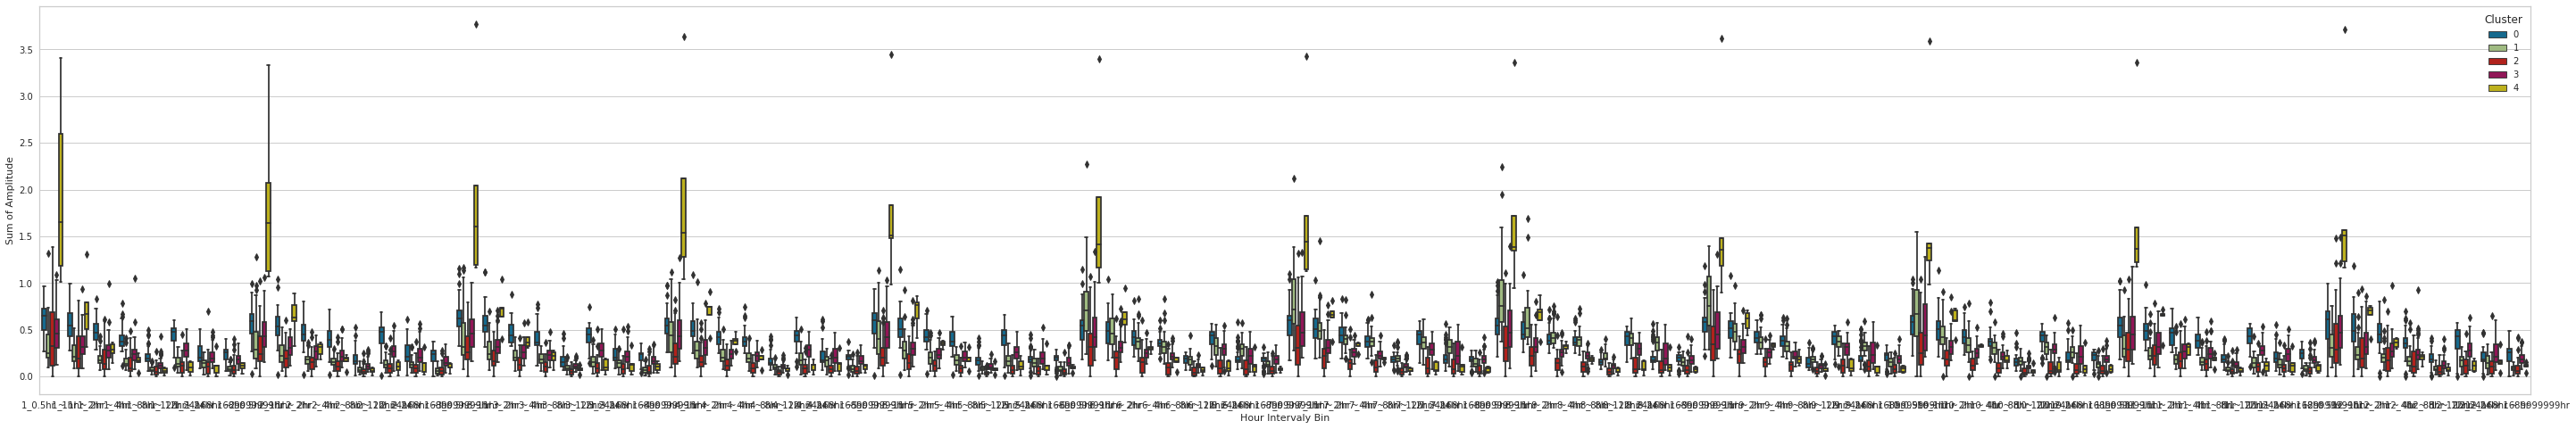

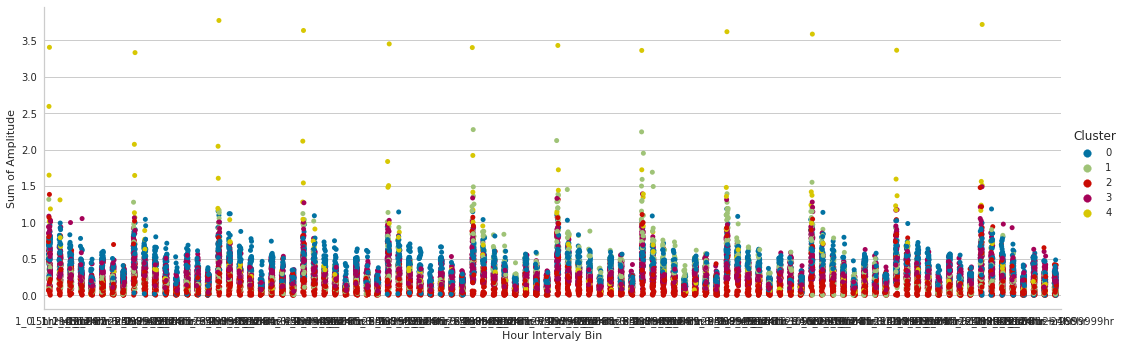

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# df_plot_raw = df_all.iloc[:, 0:11]
df_plot_raw = df_all

df_plot_raw['Cluster'] = kmeans_labels_step_2

df_plot = pd.melt(df_plot_raw.reset_index(), id_vars=['index', 'Cluster'])
df_plot.columns = ['SP_ID', 'Cluster', 'Hour Intervaly Bin', 'Sum of Amplitude']

plt.figure(figsize=(50,8))
sns.boxplot(data=df_plot,
            x='Hour Intervaly Bin', 
            y='Sum of Amplitude',
            hue='Cluster')


sns.catplot(data=df_plot,
            x='Hour Intervaly Bin', 
            y='Sum of Amplitude',
            hue='Cluster',
            height=5, # make the plot 5 units high
            aspect=3)

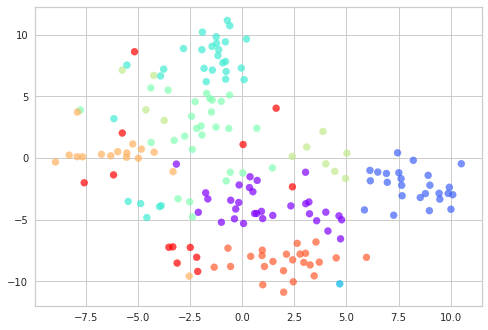

In [194]:
from sklearn.manifold import TSNE
import matplotlib.colors
import matplotlib.cm as cm

tsne = TSNE()
results_tsne = tsne.fit_transform(fft_data)

colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(np.unique(kmeans_labels_step_2))))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(kmeans_labels_step_2, colors)
plt.scatter(results_tsne[:,0], results_tsne[:,1],
            c = kmeans_labels_step_2,
            cmap = cmap,
            alpha=0.7)

In [3]:
import pandas as pd

df_ts_full = ex.clean_pge_df_ts('/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP/data_all/tt/1830564705.csv').dropna()
df_ts_half = ex.clean_pge_df_ts('/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP/data_all/tt/1830564705_half.csv').dropna()



In [105]:
def plot_ts_all(df_ts, ls_fft, save_path=None, save_dir=None, str_title=None):
    '''
    Plots both time-series and ferquency spectrum
    '''
    # plot setting
    fig = plt.figure(constrained_layout=True)
    fig.suptitle(f"Time-series and frequency-domian plots: {str_title}", fontsize=12, y=1.05)
    gs = gridspec.GridSpec(2, 1, figure=fig, width_ratios=[12], height_ratios=[6, 6]) 
    gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
    
    # Time series plot
    ax = fig.add_subplot(gs[0, 0]) # Entire first row
    ax.plot(df_ts.index, df_ts['Value'])
    ax.set_title('Scaled Time-series Consumption')
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Normalized Consumption')
    ax.set_ylim(0, 1)

    # Frequency-domian plot
    f_values, fft_values = ls_fft
    ax1 = fig.add_subplot(gs[1, 0]) # Entire first row
    ax1.scatter(f_values, fft_values, linestyle='-', color='blue', label='')
    ax1.set_title('Frequency-Amplitude')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Amplitude')
#     ax1.set_xlim(0.0001, 0.0006)
    ax1.set_xlim(0.00002, 0.0006)
    ax1.set_ylim(0, 0.05)

    if save_dir != None:
        plt.savefig(str(f"{os.path.join(save_dir, str_title)}.png"), dpi=80)
        plt.close()
        
    if save_path != None:
        plt.savefig(save_path, dpi=80)    
        plt.close()

In [116]:
hour_interval_bins = [
    [0.5, 0.75],
    [0.75, 1],
    [1, 1.25],
    [1.25, 1.5],
    [1.5, 1.75],
    [1.75, 2],
    [2, 4],
    [4, 8],
    [8, 12]
]

print('= '*30)
for hour_interval in hour_interval_bins:
    print(f"{round(1/(hour_interval[1]*3600), 5)} Hz to {round(1/(hour_interval[0]*3600), 5)} Hz")
print('= '*30)

fd.get_fft_sum_by_bins(f_values, fft_values, hour_interval_bins)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
0.00037 Hz to 0.00056 Hz
0.00028 Hz to 0.00037 Hz
0.00022 Hz to 0.00028 Hz
0.00019 Hz to 0.00022 Hz
0.00016 Hz to 0.00019 Hz
0.00014 Hz to 0.00016 Hz
7e-05 Hz to 0.00014 Hz
3e-05 Hz to 7e-05 Hz
2e-05 Hz to 3e-05 Hz
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


,0.5hr ~ 0.75hr,0.75hr ~ 1hr,1hr ~ 1.25hr,1.25hr ~ 1.5hr,1.5hr ~ 1.75hr,1.75hr ~ 2hr,2hr ~ 4hr,4hr ~ 8hr,8hr ~ 12hr
0,0.028061,0.021933,0.020462,0.011523,0.005344,0.003895,0.029765,0.057157,0.054257


/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP/data_all/9602682905.csv


Text(0, 0.5, 'Sum of Normalized Spectrum Amplitude')

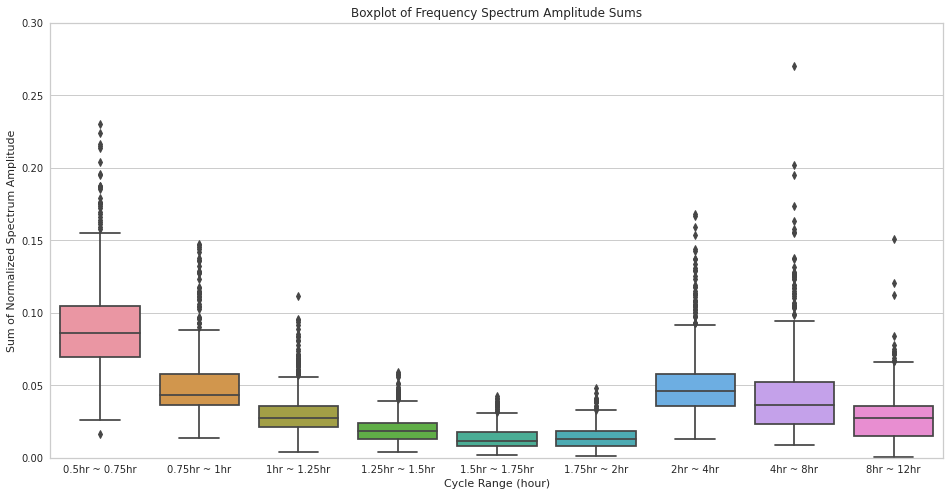

In [228]:
import pandas as pd
import seaborn as sns

def get_daily_fft_sum_bins(df_ts):
    for i, single_date in enumerate(np.unique(df_ts.date)):
        df_ts_day = df_ts.loc[df_ts.date == single_date]
        f_values, fft_values = fd.get_load_fft(df_ts_day)
        if i == 0:
            df = fd.get_fft_sum_by_bins(f_values, fft_values, hour_interval_bins)
        else:
            df = df.append(fd.get_fft_sum_by_bins(f_values, fft_values, hour_interval_bins))
    df.index = np.unique(df_ts_ex.date)
    return df


csv_in = v_typical_ts_CSVs[181]
df_ts_ex = ex.clean_pge_df_ts(csv_in, 2015).dropna()
print(csv_in)
df = get_daily_fft_sum_bins(df_ts_ex)

plt.figure(figsize=(16,8))
plt.title('Boxplot of Frequency Spectrum Amplitude Sums')
sns.boxplot(data=pd.melt(df),
            x='variable', 
            y='value')
plt.ylim([0, 0.3])
plt.xlabel('Cycle Range (hour)')
plt.ylabel('Sum of Normalized Spectrum Amplitude')

[ 4 13 17 23 34 38 41 45]


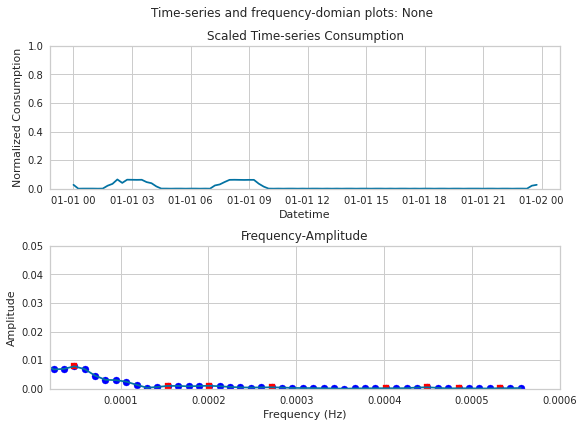

In [171]:

df_ts_ex = ex.clean_pge_df_ts(csv_in).dropna()
df_ts_ex = df_ts_ex.loc[df_ts_ex.index.date == datetime.date(year=2015,month=1,day=1)]
f_values, fft_values = fd.get_load_fft(df_ts_ex)

import peakutils
peaks_ind1 = peakutils.indexes(fft_values, thres=0.01, min_dist=0.001)
print(peaks_ind1)
plot_ts_all(df_ts_ex, fd.get_load_fft(df_ts_ex), save_path=None, save_dir=None, str_title=None)
plt.plot(f_values, fft_values)
for p in peaks_ind1:
    plt.scatter(f_values[p], fft_values[p], s=40, marker='s', color='red', label='new peaks') 

188

In [202]:
peakutils.prepare.scale(fft_values, new_range=(0.0, 1.0), eps=1e-09)

(array([1.00000000e+00, 6.20742639e-01, 9.40990342e-02, 4.43847622e-02,
        2.99700853e-02, 1.66979207e-02, 6.53364479e-03, 1.03808704e-02,
        5.13047955e-03, 1.36092284e-04, 0.00000000e+00, 5.13078491e-03,
        7.17445773e-04, 7.93485106e-03, 8.06149921e-03, 8.06813784e-03,
        9.69053555e-03, 5.69405501e-03, 4.51395262e-03, 7.94699882e-03,
        2.89627610e-03, 7.25913658e-03, 4.10528636e-03, 2.77701366e-03,
        2.69022749e-03, 6.58714051e-03, 4.14912941e-03, 4.62221681e-03,
        5.43941178e-03, 3.32697069e-03, 1.75657229e-03, 3.20432857e-03,
        2.39929956e-03, 3.94684411e-03, 2.11019774e-03, 1.65102520e-03,
        3.61974831e-03, 1.69843355e-03, 1.47615618e-03, 2.74563793e-03,
        2.97468886e-03, 5.88865154e-03, 3.61464062e-03, 3.58569653e-03,
        1.89555607e-03, 1.02259586e-03, 2.93084384e-03, 3.09750270e-03]),
 (0.0004989150403467472, 0.5236639358807473))

0.00034722222222222224 to 0.0005555555555555556
0.0002777777777777778 to 0.00034722222222222224
0.0001388888888888889 to 0.0002777777777777778
6.944444444444444e-05 to 0.0001388888888888889


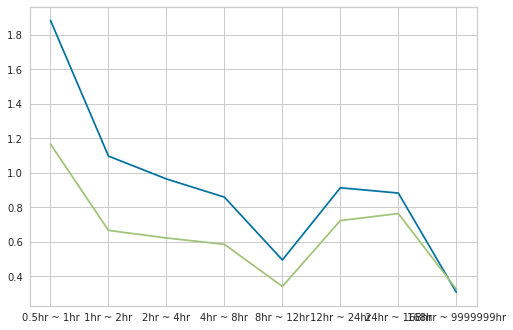

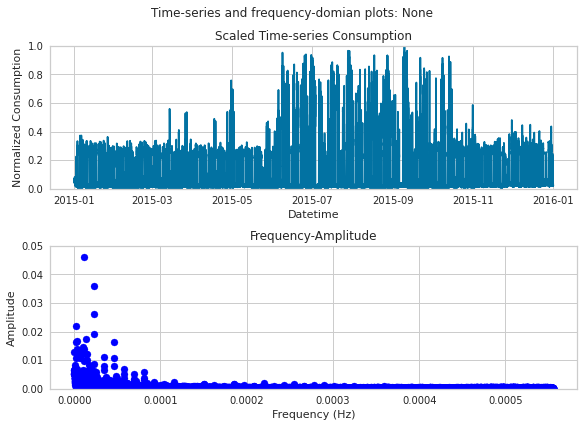

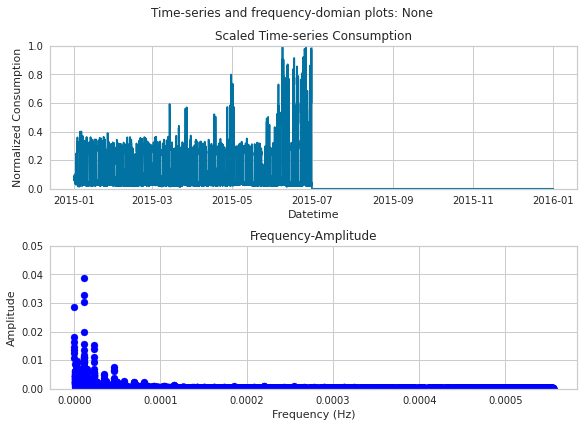

In [146]:
hour_interval_bins = [
    [0.5, 1],
    [1, 2],
    [2, 4],
    [4, 8],
    [8, 12],
    [12, 24],
    [24, 168],
    [168, 9999999],
]

# hour_interval_bins = [
#     [0.5, 0.8],
#     [0.8, 1],
#     [1, 2],
#     [2, 4],
# ]

f_values_f, fft_values_f = fd.get_load_fft(df_ts_full)
df_fft_bins_f = fd.get_fft_sum_by_bins(f_values_f, fft_values_f, hour_interval_bins)

f_values_h, fft_values_h = fd.get_load_fft(df_ts_half)
df_fft_bins_h = fd.get_fft_sum_by_bins(f_values_h, fft_values_h, hour_interval_bins)


# import matplotlib.pyplot as plt
plt.plot(df_fft_bins_f.append(df_fft_bins_h).T)

ls_fft = f_values_f, fft_values_f 
plot_ts_all(df_ts_full, ls_fft, save_path=None, save_dir=None, str_title=None)

plot_ts_all(df_ts_half, [f_values_h, fft_values_h], save_path=None, save_dir=None, str_title=None)